In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [4]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [5]:
original_dim = 28*28
dim = 10000

In [6]:
def get_opt_alpha(model: robustness_model.ClassificationModel):
    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False)
    return L3

In [7]:
def overall_robustness_method3(model: robustness_model.ClassificationModel, X):
    
    ep3s = []

    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=2000, show_pbar=False)

    for x in X:
        ep3 = model.get_eps(x, L3)
        ep3s.append(ep3)
    
    return torch.tensor(ep3s).mean()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

In [11]:
def train(sample_size=10, lr=0.001, epochs=50):

    theta = torch.nn.parameter.Parameter(torch.randn(1)[0].abs() + 0.) # theta = (0, sigma) = (sigma)
    print(theta)
    optimizer = torch.optim.Adam([theta], lr=lr)

    loss_history = []
    theta_history = []
    epsilon_history = []
    train_accs_history = []
    test_accs_history = []

    with tqdm.tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()

            dists = torch.distributions.Normal(0.0, 1)
            samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
            
            epsilons = []
            train_accs, test_accs = [], []
            for sample in samples:
                M = sample*theta
                encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
                model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
                model.bundling(X_train, y_train)

                # epsilon = overall_robustness_method3(model, X_test) # X_train
                # epsilons.append(epsilon)
                
                # Constant Alpha
                # encoder_ = robustness_model.FHRREncoder(original_dim, dim, M=M.detach())
                # model_ = robustness_model.ClassificationModel(encoder_, in_dim=original_dim, dim=dim)
                # model_.bundling(X_test, y_test)
                model_ = model.detach()
                alpha = get_opt_alpha(model_)

                ep3s = torch.stack([model.get_eps(x, alpha) for x in X_test])
                epsilons.append(ep3s.mean())

                train_accs.append((model.predict(X_train) == y_train).float().mean())
                test_accs.append((model.predict(X_test) == y_test).float().mean())

            epsilons = torch.stack(epsilons)

            # REPARAMETARIZATION TRICK
            loss = -epsilons.mean()
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())
            theta_history.append(theta.item())
            epsilon_history.append(epsilons.mean().item())

            mean_train_acc = torch.stack(train_accs).mean().item()
            mean_test_acc = torch.stack(test_accs).mean().item()
            train_accs_history.append(mean_train_acc)
            test_accs_history.append(mean_test_acc)

            pbar.update(1)
            pbar.set_postfix({
                'Loss': loss.item(),
                'Theta': theta.item(),
                'Epsilon': epsilons.mean().item(),
            })

    return loss_history, theta_history, epsilon_history, train_accs_history, test_accs_history


trial 0
Parameter containing:
tensor(0.7846, requires_grad=True)


100%|██████████| 15/15 [8:28:04<00:00, 2032.33s/it, Loss=-.036, Theta=0.77, Epsilon=0.036]      


loss_history [-0.033317066729068756, -0.033511750400066376, -0.033585354685783386, -0.03404858335852623, -0.03401914983987808, -0.03441973403096199, -0.034549348056316376, -0.034740183502435684, -0.03487193211913109, -0.03504319116473198, -0.03538366034626961, -0.03528029844164848, -0.03542514890432358, -0.0360264889895916, -0.03601718693971634]
theta_history [0.7835942506790161, 0.7825943231582642, 0.7815938591957092, 0.7805929183959961, 0.7795919179916382, 0.778590202331543, 0.7775880098342896, 0.7765849828720093, 0.775580644607544, 0.7745749950408936, 0.7735685110092163, 0.7725608944892883, 0.7715519070625305, 0.7705419063568115, 0.7695308327674866]
epsilon_history [0.033317066729068756, 0.033511750400066376, 0.033585354685783386, 0.03404858335852623, 0.03401914983987808, 0.03441973403096199, 0.034549348056316376, 0.034740183502435684, 0.03487193211913109, 0.03504319116473198, 0.03538366034626961, 0.03528029844164848, 0.03542514890432358, 0.0360264889895916, 0.03601718693971634]
tra

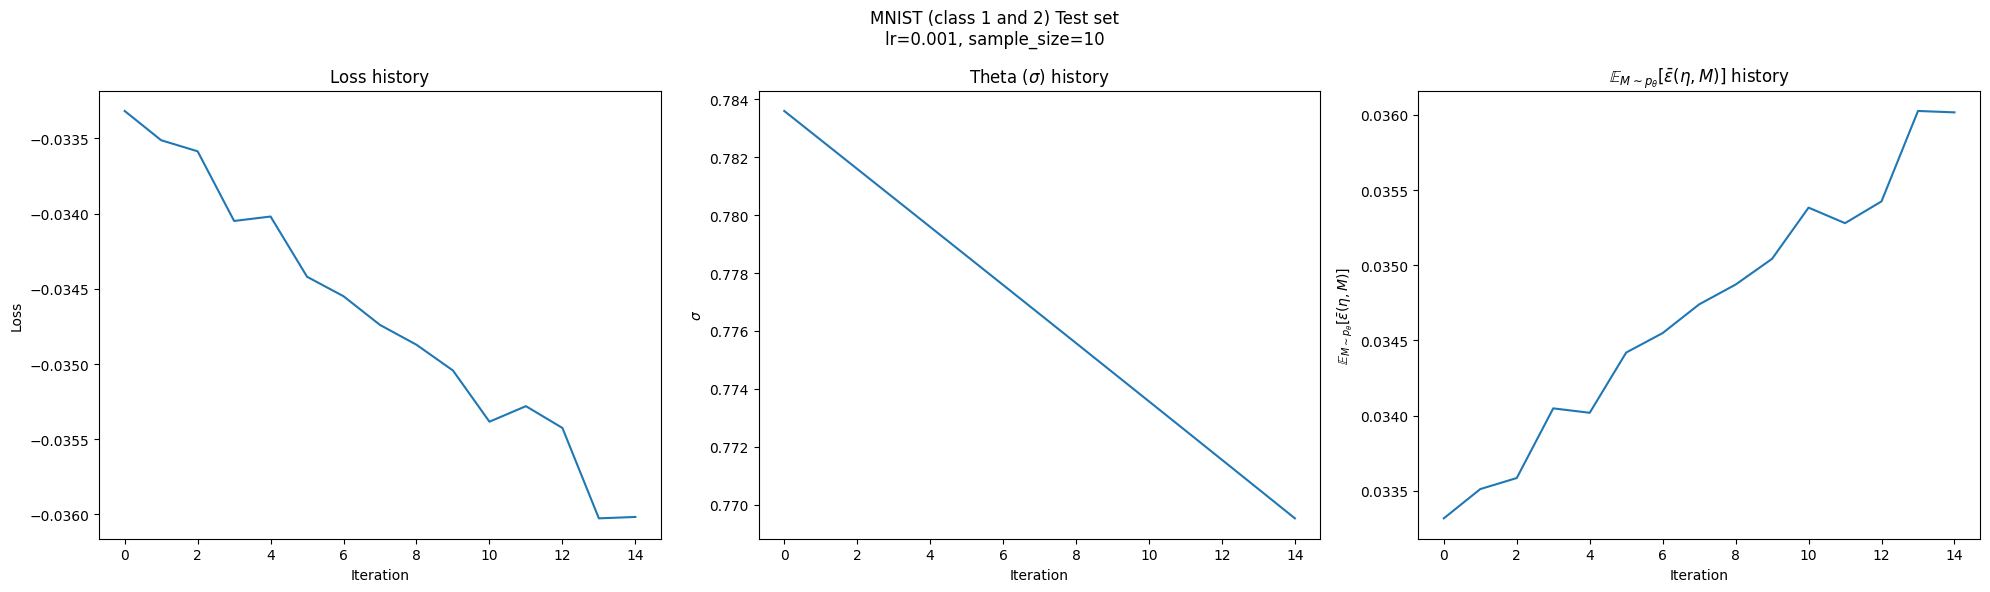

trial 1
Parameter containing:
tensor(0.5243, requires_grad=True)


100%|██████████| 15/15 [1:40:35<00:00, 402.39s/it, Loss=-.15, Theta=0.509, Epsilon=0.15]  


loss_history [-0.13773395121097565, -0.13919304311275482, -0.13995420932769775, -0.14101111888885498, -0.1415770798921585, -0.14199885725975037, -0.14238806068897247, -0.143771693110466, -0.14495809376239777, -0.14586123824119568, -0.14676788449287415, -0.147285595536232, -0.1481250524520874, -0.14905668795108795, -0.15017957985401154]
theta_history [0.5233110189437866, 0.522310733795166, 0.5213101506233215, 0.520309329032898, 0.5193079710006714, 0.5183061361312866, 0.5173037052154541, 0.5163004994392395, 0.5152965188026428, 0.514291524887085, 0.513285219669342, 0.5122776031494141, 0.511268675327301, 0.5102584362030029, 0.509246826171875]
epsilon_history [0.13773395121097565, 0.13919304311275482, 0.13995420932769775, 0.14101111888885498, 0.1415770798921585, 0.14199885725975037, 0.14238806068897247, 0.143771693110466, 0.14495809376239777, 0.14586123824119568, 0.14676788449287415, 0.147285595536232, 0.1481250524520874, 0.14905668795108795, 0.15017957985401154]
train_accs_history [0.92718

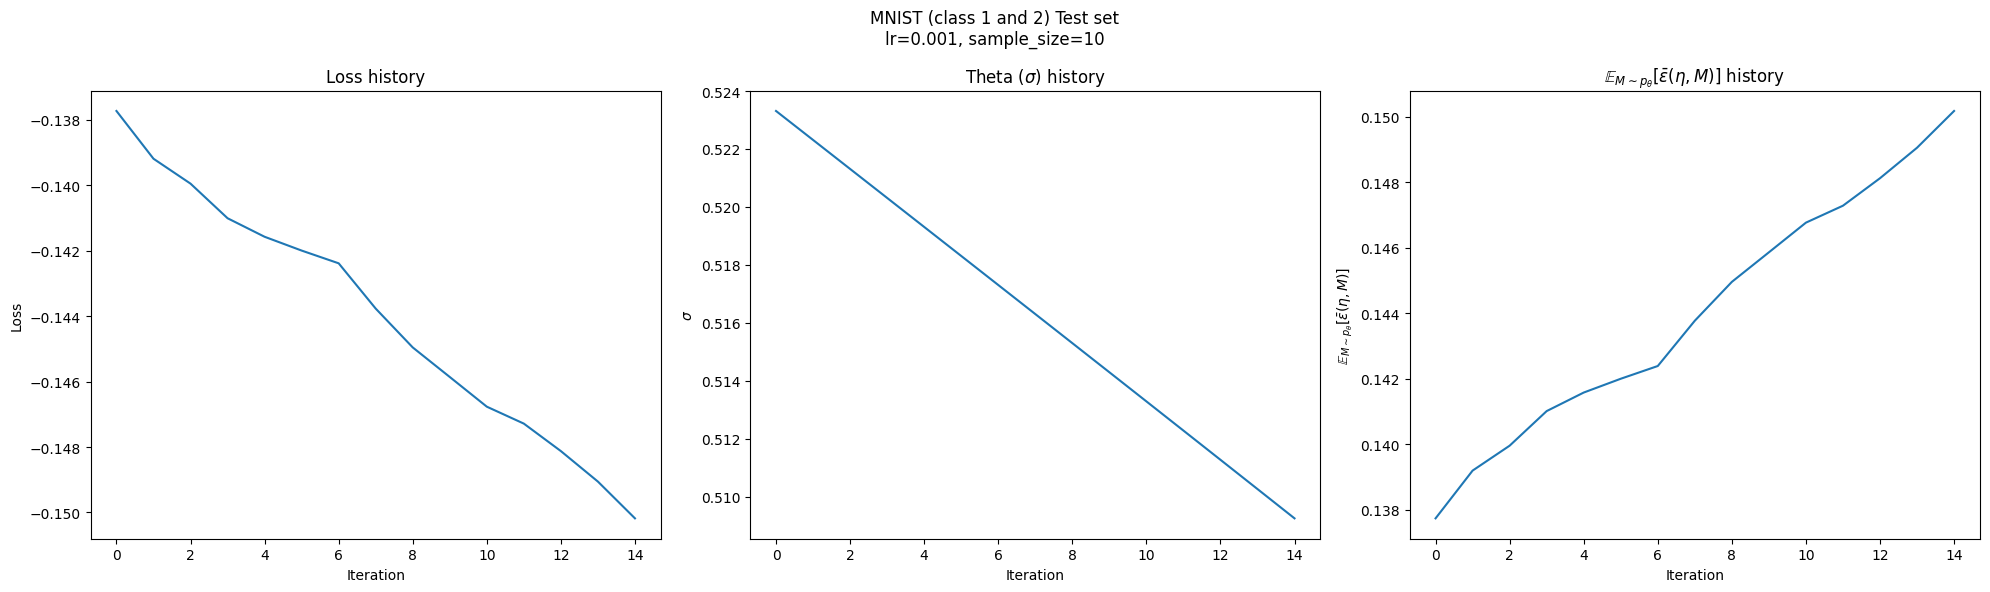

trial 2
Parameter containing:
tensor(0.0796, requires_grad=True)


100%|██████████| 15/15 [5:34:42<00:00, 1338.86s/it, Loss=-2.95, Theta=0.0946, Epsilon=2.95]  


loss_history [-3.543027400970459, -3.497295379638672, -3.440612316131592, -3.388597011566162, -3.3421592712402344, -3.2883505821228027, -3.251542568206787, -3.203512191772461, -3.164126396179199, -3.1298828125, -3.088730573654175, -3.0539016723632812, -3.021851062774658, -2.9849674701690674, -2.9541549682617188]
theta_history [0.08056745678186417, 0.08156709372997284, 0.0825667530298233, 0.08356605470180511, 0.08456625044345856, 0.08556875586509705, 0.08657247573137283, 0.08757895976305008, 0.08858665823936462, 0.08959450572729111, 0.09060236811637878, 0.0916113555431366, 0.09262215346097946, 0.09363465011119843, 0.0946463942527771]
epsilon_history [3.543027400970459, 3.497295379638672, 3.440612316131592, 3.388597011566162, 3.3421592712402344, 3.2883505821228027, 3.251542568206787, 3.203512191772461, 3.164126396179199, 3.1298828125, 3.088730573654175, 3.0539016723632812, 3.021851062774658, 2.9849674701690674, 2.9541549682617188]
train_accs_history [0.6306737661361694, 0.634338021278381

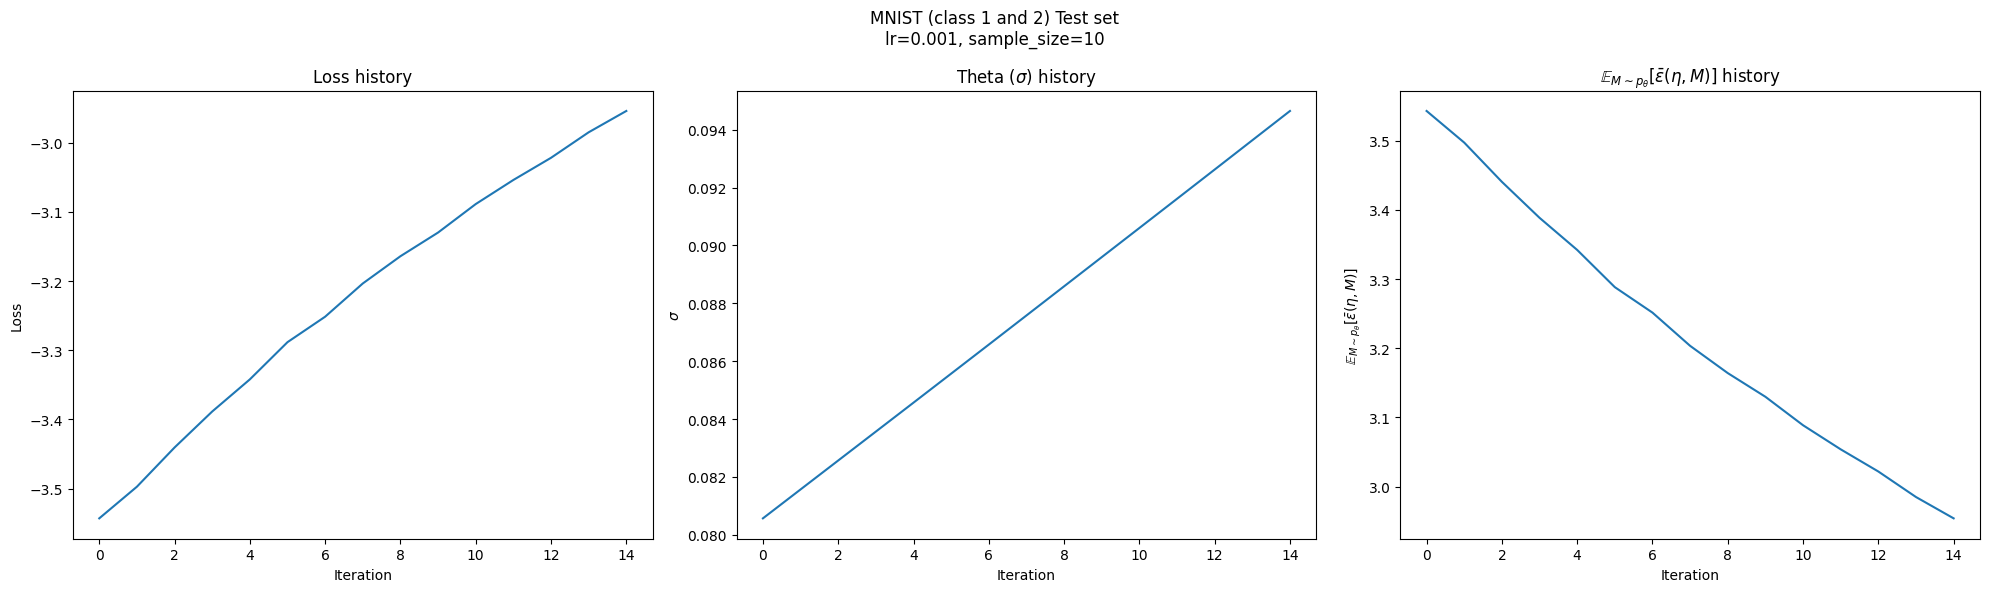

trial 3
Parameter containing:
tensor(0.0321, requires_grad=True)


 13%|█▎        | 2/15 [14:32<1:33:46, 432.83s/it, Loss=-14.2, Theta=0.0341, Epsilon=14.2]

In [12]:
sample_size = 10
lr = 0.001
epochs = 15

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history, train_accs_history, test_accs_history = train(sample_size=sample_size, lr=lr, epochs=epochs)
    print('loss_history', loss_history)
    print('theta_history', theta_history)
    print('epsilon_history', epsilon_history)
    print('train_accs_history', train_accs_history)
    print('test_accs_history', test_accs_history)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

In [10]:
sample_size = 10
lr = 0.001
epochs = 15

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history, train_accs_history, test_accs_history = train(sample_size=sample_size, lr=lr, epochs=epochs)
    print('loss_history', loss_history)
    print('theta_history', theta_history)
    print('epsilon_history', epsilon_history)
    print('train_accs_history', train_accs_history)
    print('test_accs_history', test_accs_history)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

trial 0
Parameter containing:
tensor(2.9410, requires_grad=True)


  7%|▋         | 1/15 [12:53<3:00:26, 773.29s/it, Loss=-.0828, Theta=2.94, Epsilon=0.0828]


KeyboardInterrupt: 

trial 0
Parameter containing:
tensor(0.8803, requires_grad=True)


100%|██████████| 30/30 [4:50:56<00:00, 581.89s/it, Loss=-.0454, Theta=0.72, Epsilon=0.0454]    


loss_history [-0.020597558468580246, -0.021183792501688004, -0.021757932379841805, -0.022156434133648872, -0.022682782262563705, -0.02286594733595848, -0.023984292522072792, -0.02441921830177307, -0.02508450485765934, -0.025789136067032814, -0.02661341056227684, -0.027211200445890427, -0.02769573964178562, -0.02858850359916687, -0.029630819335579872, -0.030358990654349327, -0.0312553271651268, -0.03190809488296509, -0.03289502114057541, -0.03387958183884621, -0.03463808447122574, -0.03575194254517555, -0.036570824682712555, -0.037880316376686096, -0.03874332457780838, -0.0402178056538105, -0.04152480885386467, -0.04282911866903305, -0.043998848646879196, -0.04537992551922798]
theta_history [0.8753201961517334, 0.8703165650367737, 0.8653075098991394, 0.8602898120880127, 0.8552640676498413, 0.8502268195152283, 0.8451727628707886, 0.8401033282279968, 0.8350125551223755, 0.8298987150192261, 0.8247604370117188, 0.8196001648902893, 0.8144146203994751, 0.8092014193534851, 0.8039575219154358, 

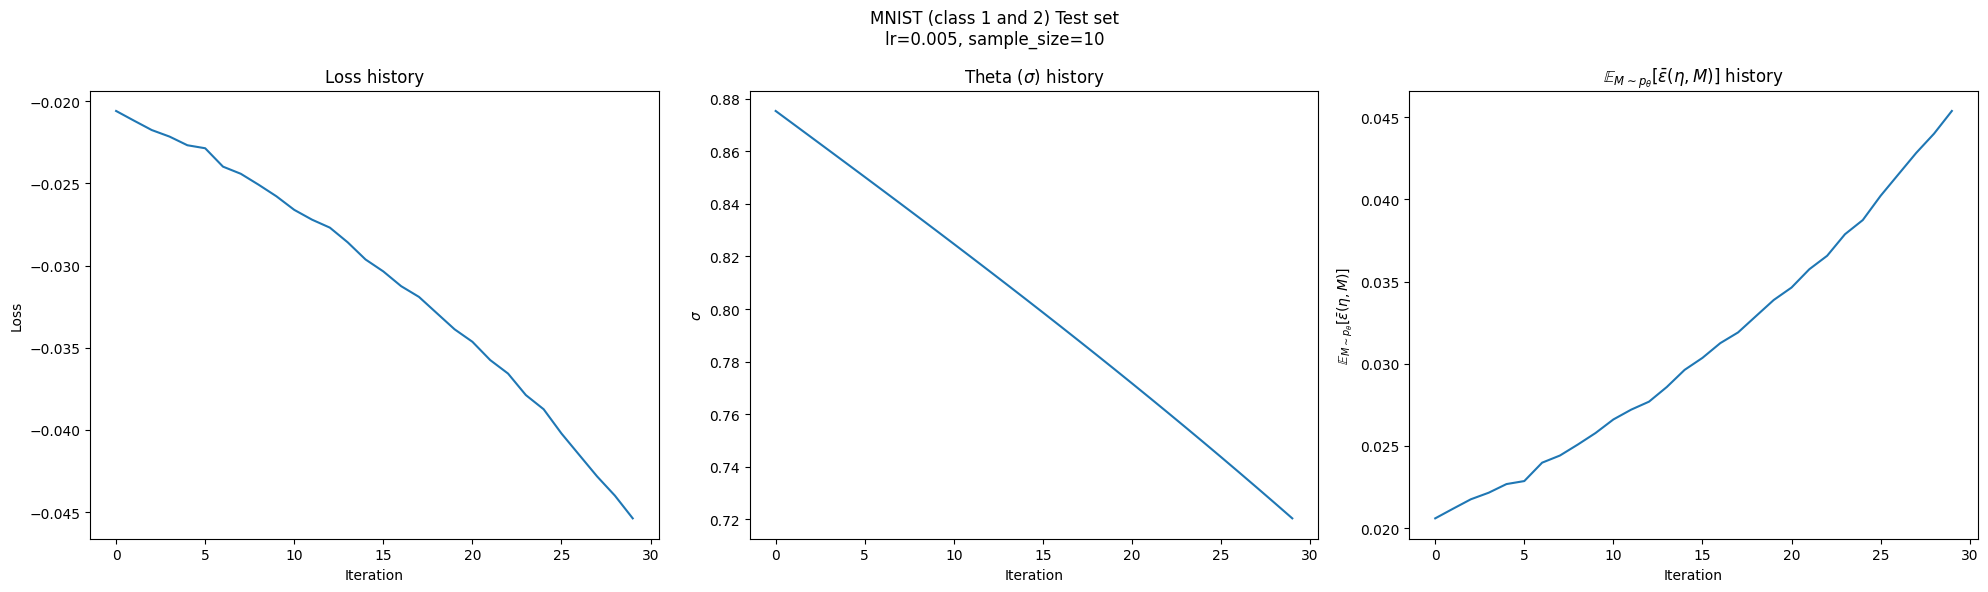

trial 1
Parameter containing:
tensor(1.6010, requires_grad=True)


100%|██████████| 30/30 [3:18:54<00:00, 397.83s/it, Loss=-.00321, Theta=1.48, Epsilon=0.00321]  


loss_history [-0.0028211467433720827, -0.0028115888126194477, -0.0027922254521399736, -0.0028618904761970043, -0.0028722058050334454, -0.00284207658842206, -0.0028166999109089375, -0.0028410148806869984, -0.0028680108953267336, -0.0028196703642606735, -0.0028277733363211155, -0.002889068564400077, -0.0029235011897981167, -0.0029631841462105513, -0.002953455550596118, -0.0029710514936596155, -0.002957526594400406, -0.0029523135162889957, -0.002889029448851943, -0.0030572423711419106, -0.0030215797014534473, -0.0029648561030626297, -0.003072400577366352, -0.003039139788597822, -0.0030736313201487064, -0.003057406982406974, -0.003071701154112816, -0.0030945977196097374, -0.003121140878647566, -0.003211474511772394]
theta_history [1.59595787525177, 1.59198796749115, 1.5885010957717896, 1.5845141410827637, 1.5818233489990234, 1.5783815383911133, 1.5747219324111938, 1.5711584091186523, 1.5673186779022217, 1.563461422920227, 1.5593183040618896, 1.5548986196517944, 1.5504765510559082, 1.546552

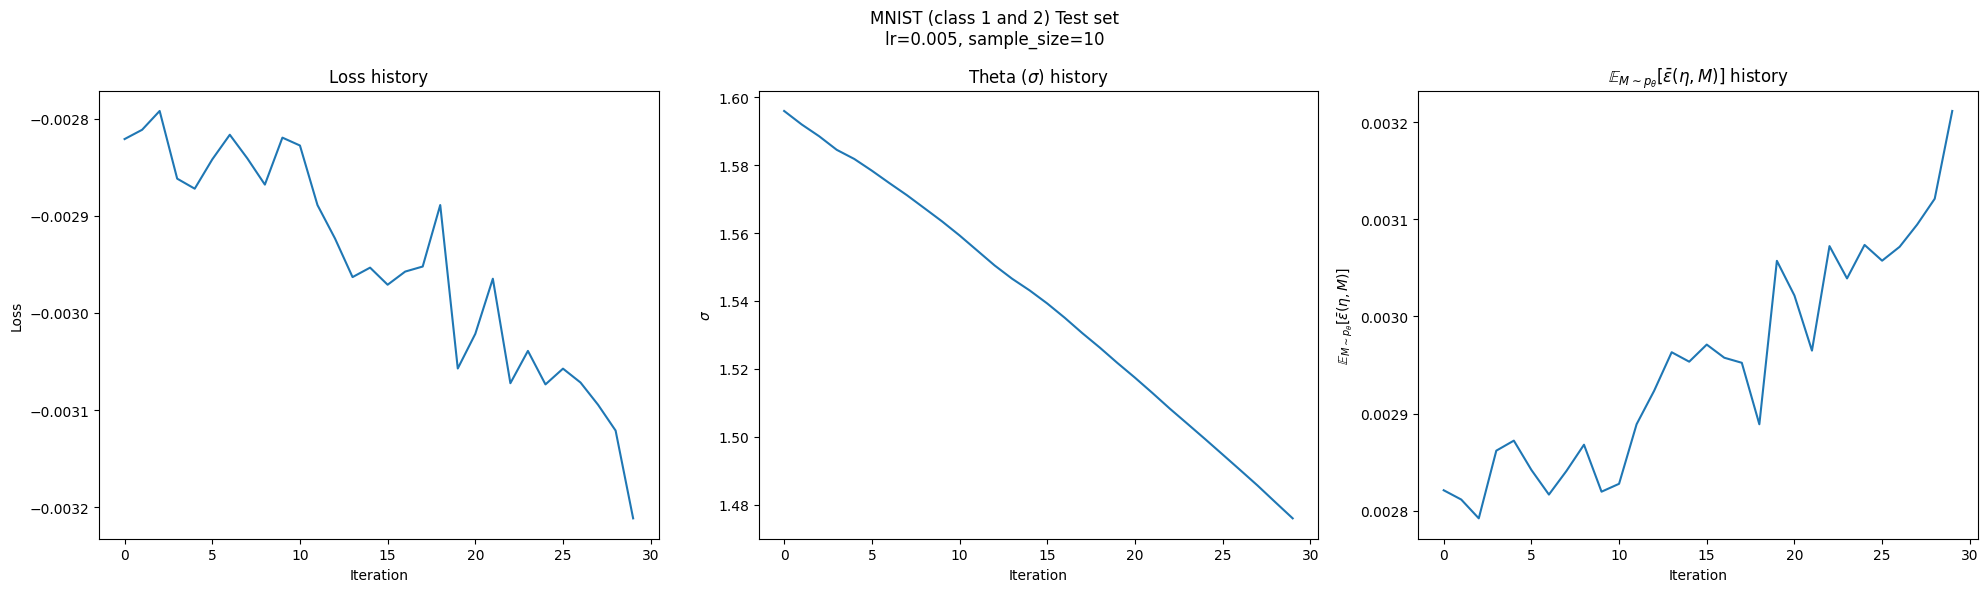

trial 2
Parameter containing:
tensor(0.9604, requires_grad=True)


100%|██████████| 30/30 [3:21:51<00:00, 403.70s/it, Loss=-.0299, Theta=0.8, Epsilon=0.0299]    


loss_history [-0.01379183679819107, -0.014044025912880898, -0.014468783512711525, -0.014707900583744049, -0.015148373320698738, -0.01566038280725479, -0.01594664342701435, -0.01640012487769127, -0.016823554411530495, -0.017160359770059586, -0.01761951856315136, -0.01810378208756447, -0.018473554402589798, -0.018883172422647476, -0.01951788179576397, -0.020296063274145126, -0.020693009719252586, -0.0213039331138134, -0.021996360272169113, -0.022477325052022934, -0.022837521508336067, -0.02362227626144886, -0.024247057735919952, -0.025032708421349525, -0.025875966995954514, -0.026547009125351906, -0.027146581560373306, -0.028279652819037437, -0.028958547860383987, -0.029907602816820145]
theta_history [0.9554153680801392, 0.9504100680351257, 0.9453969597816467, 0.9403790235519409, 0.9353516101837158, 0.9303083419799805, 0.9252496957778931, 0.9201704263687134, 0.9150705337524414, 0.9099531173706055, 0.9048109650611877, 0.8996436595916748, 0.8944557309150696, 0.8892379999160767, 0.883985459

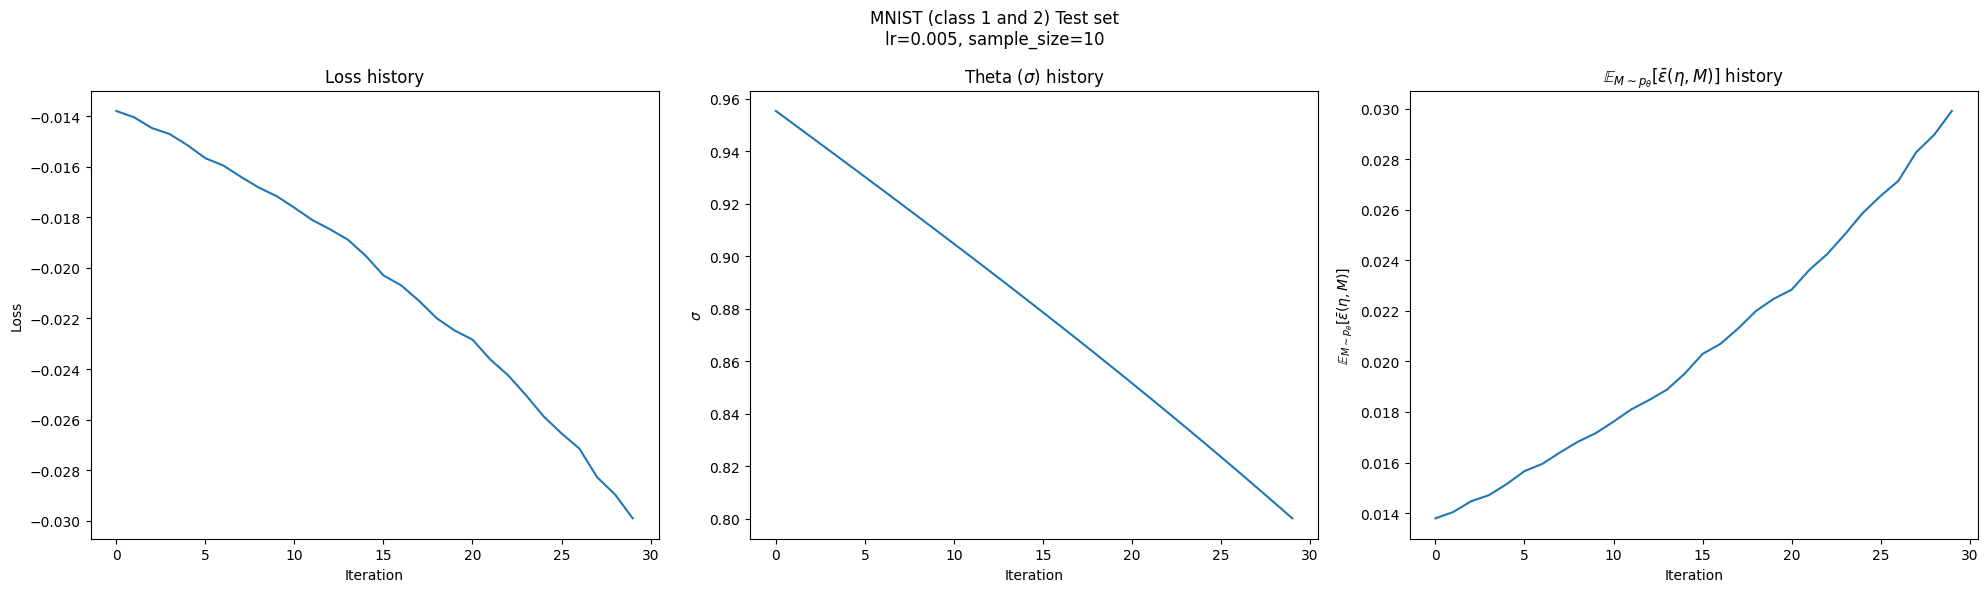

trial 3
Parameter containing:
tensor(0.5800, requires_grad=True)


100%|██████████| 30/30 [3:20:00<00:00, 400.02s/it, Loss=-.253, Theta=0.419, Epsilon=0.253]  


loss_history [-0.10041266679763794, -0.10344022512435913, -0.1064603179693222, -0.10930387675762177, -0.11246366798877716, -0.11531437933444977, -0.11909043788909912, -0.12230724096298218, -0.12594550848007202, -0.12993036210536957, -0.1336137354373932, -0.13796266913414001, -0.14257189631462097, -0.14709347486495972, -0.15172524750232697, -0.15610525012016296, -0.1613682210445404, -0.16680429875850677, -0.17202924191951752, -0.1776188462972641, -0.18374934792518616, -0.19005264341831207, -0.19775423407554626, -0.20359091460704803, -0.2108186036348343, -0.21943828463554382, -0.22659370303153992, -0.23597916960716248, -0.2443329095840454, -0.25314584374427795]
theta_history [0.5749853849411011, 0.569981575012207, 0.5649721026420593, 0.5599541664123535, 0.5549267530441284, 0.549887478351593, 0.544833779335022, 0.5397624969482422, 0.5346713662147522, 0.5295591354370117, 0.5244218707084656, 0.5192586183547974, 0.5140662789344788, 0.5088431239128113, 0.5035880208015442, 0.4982990026473999, 

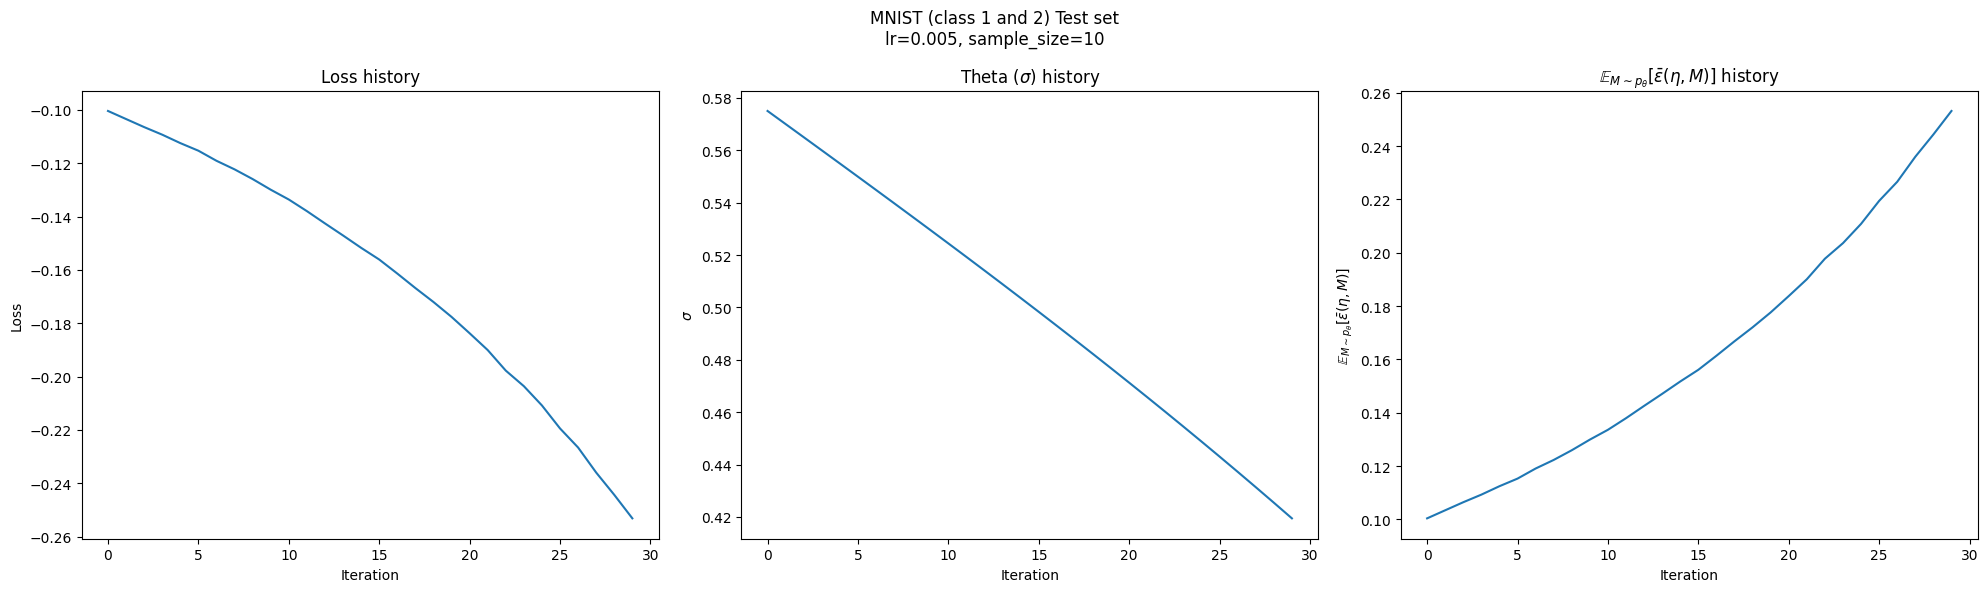

trial 4
Parameter containing:
tensor(1.3784, requires_grad=True)


 23%|██▎       | 7/30 [52:09<2:51:22, 447.06s/it, Loss=-.00378, Theta=1.34, Epsilon=0.00378]


KeyboardInterrupt: 

In [13]:
sample_size = 10
lr = 0.005
epochs = 30

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history, train_accs_history, test_accs_history = train(sample_size=sample_size, lr=lr, epochs=epochs)
    print('loss_history', loss_history)
    print('theta_history', theta_history)
    print('epsilon_history', epsilon_history)
    print('train_accs_history', train_accs_history)
    print('test_accs_history', test_accs_history)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()